# Predictor de tendencias del mercado FOREX

## Objetivo

Construir y analizar un predictor de tendencias del mercado FOREX por medio de modelo de machine learning e indicadores bursátiles que permita identificar cuando el mercado estará a la alza, baja o estable.

## Contenido

-Obtención y preparación de datos.

-Construcción de indicadores  bursátiles.

-Construcción de Features y Etiquetas para modelo de ML.

-Análisis exploratorio de datos.

-Modelos clasificadores.

-Aplicando Modelo Optimo.

-Simulación de rentabilidad.

-Backtesting.

-Conclusiones.

-Garfica de traiding activo USDTHB



In [1]:
from backtesting import Backtest, Strategy
from datetime import datetime
from backtesting.lib import crossover,plot_heatmaps
import talib
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from backtesting.lib import SignalStrategy
import time
import MetaTrader5 as mt5
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set()
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib as mpl
from matplotlib import cycler
from sklearn.linear_model import LogisticRegression
from collections import Counter

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

C:\Users\sandr\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Obtención y preparación de datos

se utilizara la plataforma MetaTrader 5 para extraccion de datos financieros con ventana  de un año para construccion del modelo

funcion para obtener datos

In [2]:
def get_data(symbol, n, timeframe=mt5.TIMEFRAME_H1):
      
        mt5.initialize()       
        utc_from = datetime.now()        
        rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n)  
        rates_frame = pd.DataFrame(rates)
        rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame['time'] = pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
        rates_frame = rates_frame.set_index('time')
        return rates_frame

se extraeran los datos de cada hora durante seis meses del activo USDTHB en periodos de 1 hora

In [3]:
data = get_data('USDTHB', 4320, timeframe=mt5.TIMEFRAME_H1)
data = data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low','close': 'Close'})
data

,Open,High,Low,Close,tick_volume,spread,real_volume
time,,,,,,,
2023-04-07 21:00:00,34.1819,34.1899,34.1709,34.1859,8,142,0
2023-04-07 22:00:00,34.1869,34.1919,34.1699,34.1919,11,122,0
2023-04-07 23:00:00,34.1909,34.1929,34.1839,34.1839,22,143,0
2023-04-10 00:00:00,34.1229,34.1359,34.1229,34.1349,13,733,0
2023-04-10 01:00:00,34.1349,34.1719,34.1339,34.1689,25,353,0
...,...,...,...,...,...,...,...
2023-12-19 20:00:00,34.8070,34.8510,34.7900,34.8100,269,110,0
2023-12-19 21:00:00,34.8200,34.8270,34.7900,34.8270,153,100,0
2023-12-19 22:00:00,34.8250,34.8550,34.8000,34.8430,238,80,0


Text(0.5, 1.0, 'Price Close USDTHB')

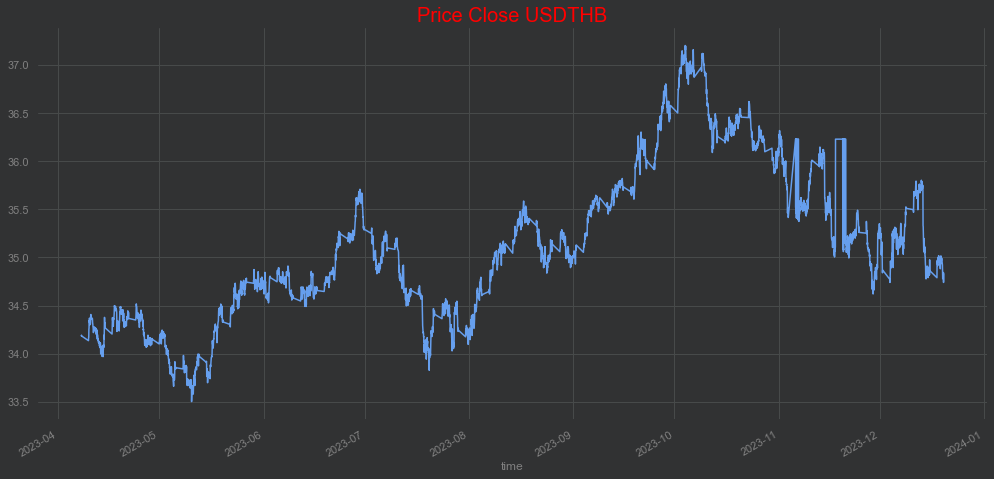

In [4]:
data['Close'].plot(figsize=(17,8))
plt.title('Price Close USDTHB',color='red', fontsize=20)

Se observa una subida muy fuerte en el precio en los meses de Agosto a Octubre 2023 con una posterior caída.

## Construcción de indicadores bursátiles

Para la realización del modelo basare los datos en la construcción de diferentes indicadores del mercado enfocados en medir la fuerza de la tendencia de los precios como lo son medias moviles, bandas de bolinguer,RSI,MACD,ROC. Para equilibrar los valores se calculará  el porcentaje con respecto al precio de cierre.

In [5]:
def calculo_indicadores(data):
    close = data.Close.values
    #medias moviles
    sma10 = talib.SMA(data.Close, 10)
    sma20 = talib.SMA(data.Close, 20)
    sma50 = talib.SMA(data.Close, 50)
    sma100 = talib.SMA(data.Close, 100)
    #bandas de bolinger
    upper, middle, lower = talib.BBANDS(data.Close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    # se crean porcentajes
    data['X_SMA10'] = (close - sma10) / close
    data['X_SMA20'] = (close - sma20) / close
    data['X_SMA50'] = (close - sma50) / close
    data['X_SMA100'] = (close - sma100) / close

    data['X_DELTA_SMA10'] = (sma10 - sma20) / close
    data['X_DELTA_SMA20'] = (sma20 - sma50) / close
    data['X_DELTA_SMA50'] = (sma50 - sma100) / close

    # Indicator features
    data['X_MOM'] = data.Close.pct_change(periods=2)
    data['X_BB_upper'] = (upper - close) / close
    data['X_BB_lower'] = (lower - close) / close
    data['X_BB_width'] = (upper - lower) / close

    # Some datetime features for good measure
    data['X_day'] = data.index.dayofweek
    data['X_hour'] = data.index.hour

    #RSI

    data['X_RSI'] = talib.RSI(data['Close'].values, timeperiod=14)

    #desviacion estandar
    stddev_period = 5  # Periodo para el cálculo de la desviación estándar
    data['X_STDDEV'] = talib.STDDEV(data['Close'].values, timeperiod=stddev_period, nbdev=1)


    #indicador MAC

    macd, macd_signal_line, _ = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)

    data['X_MACD'] = macd  # Línea MACD
    data['X_MACD_Signal'] = macd_signal_line  # Línea de señal del MACD

    #indicador ROC

    roc_period = 20  # Período para el cálculo del ROC

    data['X_ROC'] = talib.ROC(data['Close'].values, timeperiod=roc_period)

    #se borran los nan que se crean
    data = data.dropna()

    return data

In [6]:
data = calculo_indicadores(data)
data.head(3)

,Open,High,Low,Close,tick_volume,spread,real_volume,X_SMA10,X_SMA20,X_SMA50,...,X_BB_upper,X_BB_lower,X_BB_width,X_day,X_hour,X_RSI,X_STDDEV,X_MACD,X_MACD_Signal,X_ROC
time,,,,,,,,,,,,,,,,,,,,,
2023-04-14 00:00:00,33.9649,33.9879,33.9639,33.9729,10,313,0,-0.001342,-0.002449,-0.004883,...,0.005035,-0.000137,0.005172,4,0,32.863534,0.020314,-0.040275,-0.036577,-0.442505
2023-04-14 01:00:00,33.9729,33.9829,33.9729,33.9829,6,203,0,-0.001006,-0.001992,-0.004428,...,0.004689,-0.000704,0.005393,4,1,35.109446,0.019823,-0.040979,-0.037457,-0.322648
2023-04-14 02:00:00,33.9839,34.0039,33.9839,33.9979,51,143,0,-0.000553,-0.001430,-0.003838,...,0.004175,-0.001316,0.005491,4,2,38.436309,0.017545,-0.039867,-0.037939,-0.240611


En la última línea de la función se eliminaron valores NA

## Construcción de Features y Etiquetas para modelo de ML

Ahora se construirán las Features y etiquetas del modelo. para esta última calculara la variación del precio de cierre cada 30 horas prediciendo que si hay un cambio positivo el precio estará al alza y su etiqueta será 1, por el contrario si la variación es negativa el precio será a la baja y su valor será -1 pero si hay una variación entre -.004, .004 se considerara muy pequeña y se asumirá que no es suficiente para predecir la tendencia del mercado y su valor será 0. Se espera encontrar patrones que interrelacionen los indicadores bursátiles y los cambios de precio.

In [7]:
def construir_X_y(data):
    X = data.filter(like='X').values
    
    """Return dependent variable y"""
    y = data.Close.pct_change(30).shift(-30)  # variacion cada 30 horas
    y[y.between(-.004, .004)] = 0             # pequeñas variaciones
    y[y > 0] = 1                              # variacion positiva
    y[y < 0] = -1                             #variacion negativa
    
    isnan = np.isnan(y)
    X = X[~isnan] # ~ significa NOT
    y = y[~isnan]
    
    return X,y

## Análisis exploratorio de datos

Grafica de etiquetas

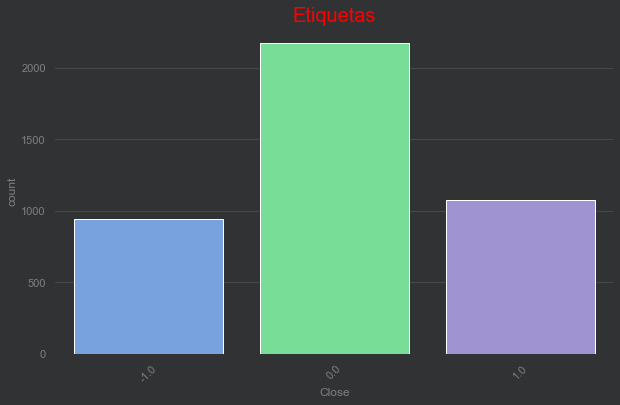

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(construir_X_y(data)[1])
plt.xticks(rotation=45)
plt.title('Etiquetas',color='red', fontsize=20)
plt.show()

Se observa un gran desbalanceo entre las 3 etiquetas por lo que será necesario balancearlas

In [9]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)
X_over, y_over = undersample.fit_resample(construir_X_y(data)[0],construir_X_y(data)[1])

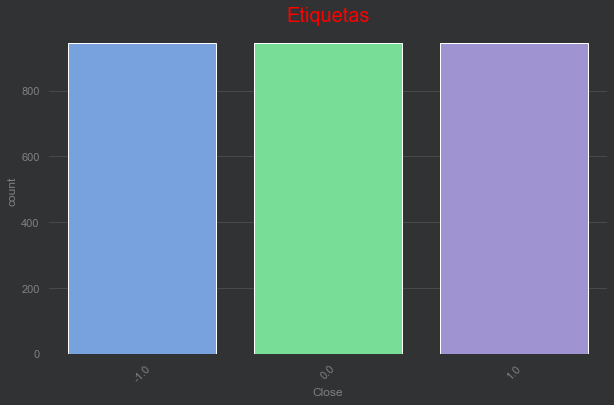

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(y_over)
plt.xticks(rotation=45)
plt.title('Etiquetas',color='red', fontsize=20)
plt.show()

Ahora están balanceadas por la cantidad mas baja con el fin de que no se asuman valores que puedan afectar el modelo

con el fin de ver correlaciones entre los datos se realiza el siguiente heatmap

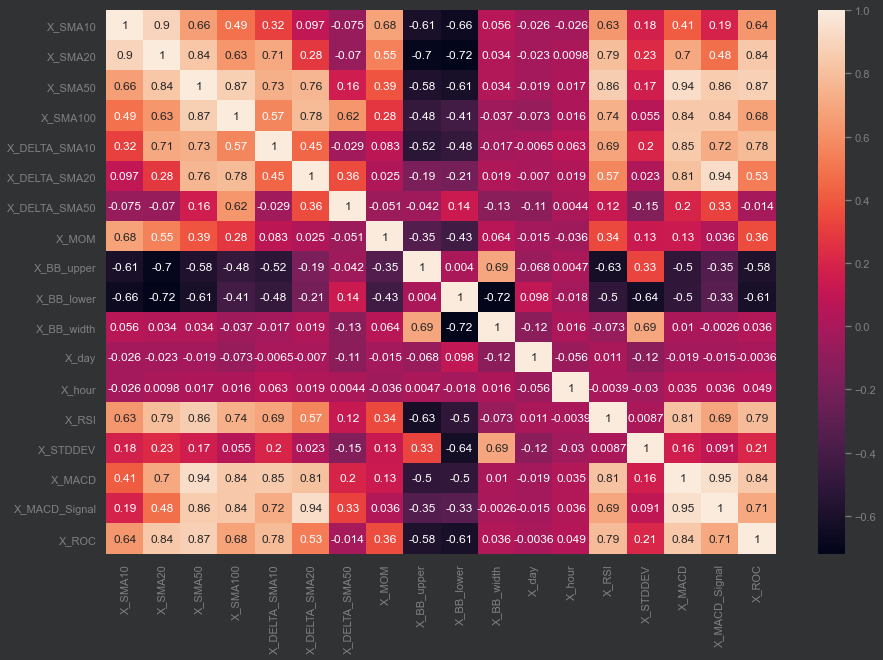

In [11]:
df_X_over = pd.DataFrame(X_over)
df_X_over.columns = data.filter(like='X').columns
plt.figure(figsize=(15,10))
sns.heatmap(df_X_over.corr(), annot=True)
plt.show()

hay mayores correlaciones la SMA de 20 y 50, además del RSI que tienen buena correlación con el MACD, el ROC y la BB_Upper. Por lo tanto es mejor observarlas más detenidamente

In [12]:
df_y_over = pd.DataFrame(y_over)
df_y_over.columns = ['etiquetas']
df_ =  pd.concat([df_X_over, df_y_over], axis=1)


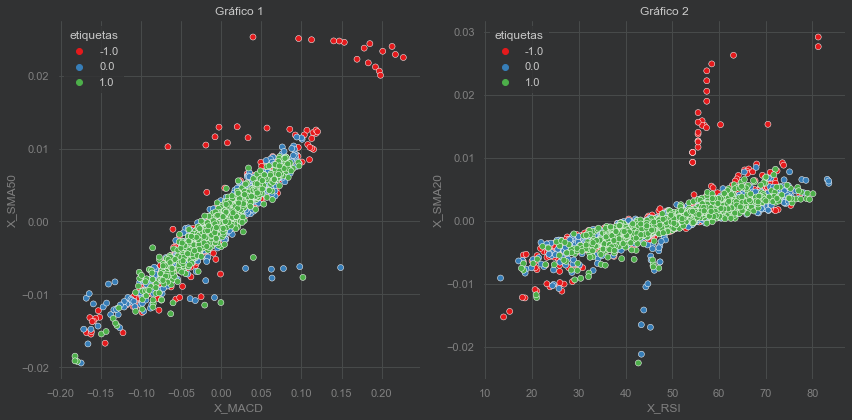

In [13]:
# Cria uma figura e seus subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Primeiro subplot
sns.scatterplot(data=df_, x='X_MACD', y='X_SMA50', hue='etiquetas', palette='Set1', ax=axes[0])
axes[0].set_title('Gráfico 1')

# Segundo subplot
sns.scatterplot(data=df_, x='X_RSI', y='X_SMA20', hue='etiquetas', palette='Set1', ax=axes[1])
axes[1].set_title('Gráfico 2')

# Ajusta o layout
plt.tight_layout()

# Exibe os gráficos lado a lado
plt.show()

se observa en estos parametros que hay buen correlacion cuando hay compra aunuqe con algunos outliers

# Modelos clasificadores

Ahora se probarán varios modelos para escoger el que mejor Accuracy muestre para este caso.

## Modelos Multiclase

entrenamiento y escalamiento de datos

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over,random_state= 42,shuffle=True,test_size=.2)
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.fit_transform( X_test)

In [15]:
def logistic_model(C_,solver_,multiclass_):
    Logistic_regression_model = LogisticRegression(random_state=42,solver=solver_,multi_class=multiclass_,n_jobs=1,C=C_)
    return Logistic_regression_model

In [16]:
model = logistic_model(1,'saga','multinomial')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[92 52 47]
 [52 80 58]
 [63 47 76]]
0.43738977072310403


es una accuracy demasiado bajo se intentara probar diferentes clases y listas con el fin de mejorarlo

In [17]:
multiclass = ['ovr','multinomial']
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
scores = []
params=[]
for i in multiclass:
    for j in solver_list:
        try:
            model = logistic_model(1,j,i)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            params.append(i + '-'+ j)
            accuraccy = accuracy_score(y_test,predictions)
            scores.append(accuraccy)
        except:
            None  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'ovr-liblinear'),
  Text(1, 0, 'ovr-newton-cg'),
  Text(2, 0, 'ovr-lbfgs'),
  Text(3, 0, 'ovr-sag'),
  Text(4, 0, 'ovr-saga'),
  Text(5, 0, 'multinomial-newton-cg'),
  Text(6, 0, 'multinomial-lbfgs'),
  Text(7, 0, 'multinomial-sag'),
  Text(8, 0, 'multinomial-saga')])

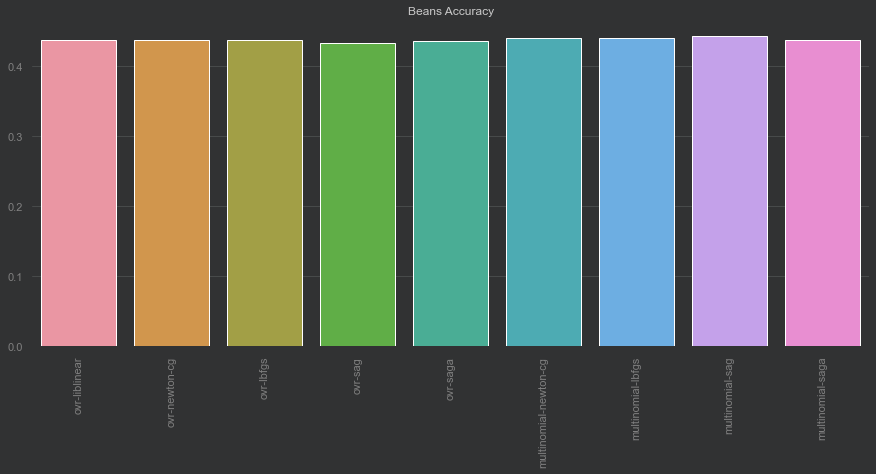

In [18]:
fig = plt.figure(figsize=(15,6))
sns.barplot(x=params,y=scores).set_title('Beans Accuracy')
plt.xticks(rotation=90)

en todos los casos se evidencia un accuracy muy parecido por lo que es necesario probar otros modelos y optimizaciones.Se probaran 6 diferentes modelos con diferentes parámetros optimizándooslos con el método de ensamble Baggin Classifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [20]:
 estimators = {
        'LogisticRegression' : LogisticRegression(),
        'SVC' : SVC(),
        'LinearSVC' : LinearSVC(),
        'SGD' : SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
        'DecisionTreeClf' : DecisionTreeClassifier(),
        'RandomTreeForest' : RandomForestClassifier(random_state=0)
    }

In [21]:
   for name, estimator in estimators.items():
        bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=50).fit(X_train, y_train)
        bag_predict = bag_class.predict(X_test)
        print('='*64)
        print('SCORE Bagging with {} : {}'.format(name, accuracy_score(bag_predict, y_test)))

SCORE Bagging with LogisticRegression : 0.43033509700176364
SCORE Bagging with SVC : 0.49206349206349204
SCORE Bagging with LinearSVC : 0.43209876543209874
SCORE Bagging with SGD : 0.4038800705467372
SCORE Bagging with DecisionTreeClf : 0.7213403880070547
SCORE Bagging with RandomTreeForest : 0.6825396825396826


Dados los resultados se escoge el clasificador DecisionTreeClf dado que presento los mejores resultados con accuracy de 0.72

Ahora se optimizara el valor de los estimadores

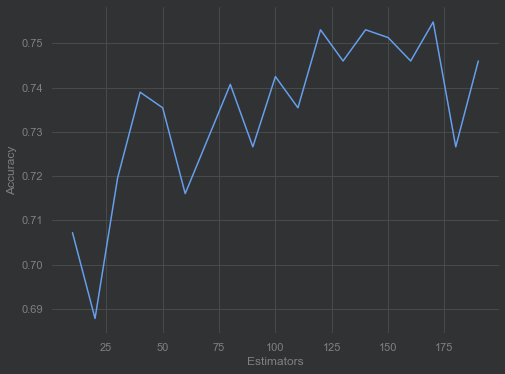

<Figure size 432x288 with 0 Axes>

In [22]:
bag_class = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50).fit(X_train, y_train)
bag_predict = bag_class.predict(X_test)

estimators = range(10, 200, 10)
df_accuracy = pd.DataFrame(columns=['accuracy', 'estimador'])
for i in estimators:
    bag_class = BaggingClassifier(DecisionTreeClassifier(), n_estimators=i).fit(X_train, y_train)
    bag_predict = bag_class.predict(X_test)
    
    data_row = {
        'accuracy': accuracy_score(y_test, bag_predict),
        'estimador': i 
    }

    df_accuracy = pd.concat([df_accuracy, pd.DataFrame([data_row])], ignore_index=True)
   
    
    indice_max = df_accuracy['accuracy'].idxmax()

df_accuracy    
plt.figure(figsize=(8, 6))
plt.plot(df_accuracy['estimador'].to_numpy(), df_accuracy['accuracy'].to_numpy())
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('Boost.png')    

In [23]:
df_accuracy.loc[df_accuracy['accuracy'].idxmax()]

accuracy     0.75485
estimador        170
Name: 16, dtype: object

el mejor estimador posible es 170 estimadores alcanzando un accuracy de 0.75

## Aplicando Modelo Optimo

Dado los parametros encontrados se entrenara modelo

In [44]:
model_final = BaggingClassifier(DecisionTreeClassifier(), n_estimators=170).fit(X_train, y_train)
model_final.fit(X_train, y_train)
predictions = model_final.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[162  21   8]
 [ 29 130  31]
 [ 18  36 132]]
0.7477954144620811


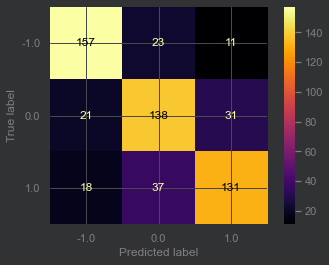

In [25]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='inferno')
plt.show()

se obtiene finalmente un accuracy del 75%, se trabajara con este modelo y se simulara una rentabilidad aplicada a una fracción de los últimos meses del año.

## Simulación de rentabilidad

Se tomara el 40% de los datos de los últimos registros de la data para realizar Backtesting y probar el retorno de esta estrategia.

Posteriormente se aplicara el modelo encontrado a los datos para predecir las tendencias.

In [26]:
data_X = calculo_indicadores(data)

In [27]:
def data_predict_x(data_X,model_final):
    
    X_final = data_X.filter(like='X')
    X_final = X_final.tail(round(len(X_final)*0.4))
    columnas_seleccionadas = ['Open', 'High','Low','Close']
    data_X = X_final.join(data[columnas_seleccionadas])
    data_X
    
    st_x_ = StandardScaler()
    X_final_escalados = st_x_.fit_transform(X_final)
    pred_final =  model_final.predict(X_final_escalados)
    
    
    return pred_final,data_X 

los datos seleccionados son los siguientes

In [28]:
datos_back_Testing = data_predict_x(data_X,model_final)[1]
datos_back_Testing

,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_DELTA_SMA10,X_DELTA_SMA20,X_DELTA_SMA50,X_MOM,X_BB_upper,X_BB_lower,...,X_hour,X_RSI,X_STDDEV,X_MACD,X_MACD_Signal,X_ROC,Open,High,Low,Close
time,,,,,,,,,,,,,,,,,,,,,
2023-09-13 04:00:00,0.000693,0.000036,0.002053,0.001770,-0.000657,0.002017,-0.000284,0.001476,0.002510,-0.002583,...,4,54.098561,0.036963,0.012919,0.017088,0.202492,35.671,35.672,35.6000,35.629
2023-09-13 05:00:00,0.002141,0.001477,0.003581,0.003317,-0.000664,0.002104,-0.000264,0.000421,0.001062,-0.004015,...,5,60.344355,0.044055,0.017760,0.017222,0.314837,35.629,35.719,35.6275,35.686
2023-09-13 06:00:00,0.001469,0.000857,0.002942,0.002714,-0.000613,0.002085,-0.000227,0.001038,0.001710,-0.003423,...,6,57.393396,0.039354,0.019755,0.017729,0.120709,35.686,35.702,35.6580,35.666
2023-09-13 07:00:00,0.002162,0.001674,0.003792,0.003615,-0.000489,0.002118,-0.000177,0.000392,0.000972,-0.004320,...,7,60.894448,0.023888,0.023806,0.018944,0.269633,35.666,35.732,35.6575,35.700
2023-09-13 08:00:00,0.002179,0.001908,0.004020,0.003906,-0.000270,0.002112,-0.000114,0.001290,0.000878,-0.004695,...,8,62.078826,0.029145,0.027665,0.020688,0.202020,35.699,35.729,35.6775,35.712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19 20:00:00,-0.002020,-0.003397,-0.003583,-0.005234,-0.001377,-0.000186,-0.001652,0.000632,0.007603,-0.000809,...,20,33.911911,0.030669,-0.037349,-0.017287,-0.206410,34.807,34.851,34.7900,34.810
2023-12-19 21:00:00,-0.001097,-0.002728,-0.003077,-0.004484,-0.001631,-0.000349,-0.001408,0.000575,0.007103,-0.001647,...,21,37.293991,0.016963,-0.038228,-0.021475,-0.357633,34.820,34.827,34.7900,34.827
2023-12-19 22:00:00,-0.000267,-0.002141,-0.002620,-0.003773,-0.001874,-0.000479,-0.001154,0.000948,0.006622,-0.002339,...,22,40.386162,0.018687,-0.037205,-0.024621,-0.251925,34.825,34.855,34.8000,34.843


las predicciones arrojadas para cada hora se agrupan de la siguiente manera

In [29]:
prediccion_tendencia = data_predict_x(data_X,model_final)[0]


No handles with labels found to put in legend.


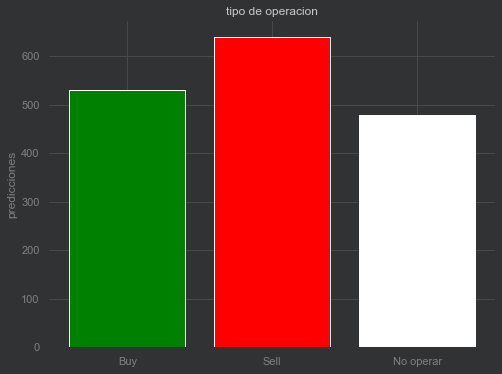

In [30]:
# Objeto Counter con valores y sus frecuencias
conteo =  Counter(prediccion_tendencia)

# Extraer claves y valores del objeto Counter
valores = list(conteo.keys())
frecuencias = list(conteo.values())

# Etiquetas para las leyendas
etiquetas = ['No operar', 'Sell', 'Buy']
# Colores para cada barra
colores = ['white', 'red', 'green']
# Graficar en barras con leyendas
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.bar(valores, frecuencias, color=colores , tick_label=etiquetas)  # Crear el gráfico de barras con etiquetas en el eje x
plt.ylabel('predicciones')  # Etiqueta del eje y
plt.title('tipo de operacion')  # Título del gráfico

# Mostrar leyendas
plt.legend()

plt.show()

## Backtesting

Una vez realizadas las predicciones se procederá por medio de Backtesting a validar la calidad y la precisión del modelo, mediante la comparación de rentabilidad de los resultados reales de las posiciones de trading y las medidas de riesgo generada por los modelo.

para ello se utilizará la librería de backtesting simulando una cuenta para hacer traiding con USD10000 colocando Take profit y Stop Loss del 1.82% si es compra y 1% si la predicción es venta. se realizará una sola operación a la vez.

In [31]:
from backtesting import Backtest, Strategy

#Creamos la estrategia y el backtest
class MLTrainOnceStrategy(Strategy):
    slPercent_buy = 0.982
    tpPercent = 1
    slPercent_sell = 1.01
    
    def init(self):
        #modelo de ML crado antes
        #self.clf = model_final
        self.clf = prediccion_tendencia
        self.i = 0 
    def next(self):

       
        #se toma nuevamente la data que contiene datos e indicadores para poder hacer el backtrader y que entienda en el lenguaje financiero
        high, low, close = self.data.High, self.data.Low, self.data.Close
        #devuelve la ultima fecha del data es donde nos encontramos
        current_time = self.data.index[-1]


        self.i = self.i +1
        forecast = self.clf[self.i]
        

        
       
   

     
        price = close[-1] 
        
        
        #condicion
        if forecast == 1 and not self.position.is_long:
            self.buy(sl = price * self.slPercent_buy, tp = ((price -(price * self.slPercent_buy))*self.tpPercent)+price)
        elif forecast == -1 and not self.position.is_short:
            self.sell(sl = price * self.slPercent_sell, tp = ((price -(price * self.slPercent_sell))*self.tpPercent)+price)
        elif forecast == 0 and not self.position.is_long and not self.position.is_short:
            self.position.close()



bt = Backtest(datos_back_Testing, MLTrainOnceStrategy,cash = 100000)

Resultados del analisis

In [32]:
bt.run()

Start                     2023-09-13 04:00:00
End                       2023-12-20 00:00:00
Duration                     97 days 20:00:00
Exposure Time [%]                   84.778654
Equity Final [$]                289489.493636
Equity Peak [$]                 293756.710176
Return [%]                         189.489494
Buy & Hold Return [%]               -2.242555
Return (Ann.) [%]                  4303.57274
Volatility (Ann.) [%]             9290.432597
Sharpe Ratio                         0.463226
Sortino Ratio                      132.132246
Calmar Ratio                       130.412924
Max. Drawdown [%]                  -32.999588
Avg. Drawdown [%]                   -1.164909
Max. Drawdown Duration       34 days 13:00:00
Avg. Drawdown Duration        1 days 19:00:00
# Trades                                  239
Win Rate [%]                        50.627615
Best Trade [%]                        2.14037
Worst Trade [%]                          -1.8
Avg. Trade [%]                    

Algunos indicadores importantes de la simulación:

se presento retabilidad de 189% 

Máxima perdida Drawdown de -32%. 

Rentabilidad Mensual aproximada para este activo de 58%

## Garfica de traiding activo USDTHB

Para ver el detalle de cada trade a lo largo del tiempo se graficaran todas las operaciones.

In [33]:
bt.plot()

Row(id='1338', ...)

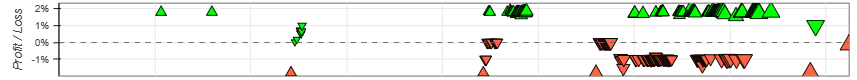

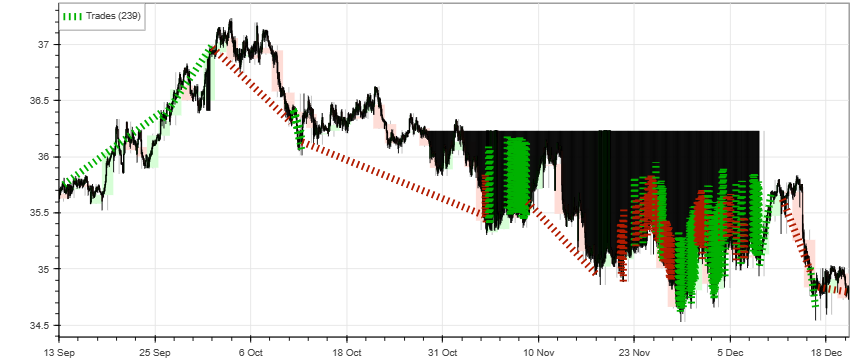

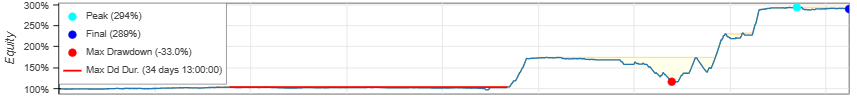

In [42]:
from IPython.display import display, Image

# Lista de rutas de las imágenes
rutas_imagenes = ['C:\\Users\\sandr\\Downloads\\bokeh_plot_1.png','C:\\Users\\sandr\\Downloads\\bokeh_plot_2.png', 'C:\\Users\\sandr\\Downloads\\bokeh_plot_3.png']
# Reemplaza con las rutas reales de tus imágenes

# Mostrar cada imagen en secuencia
for ruta_imagen in rutas_imagenes:
    display(Image(filename=ruta_imagen))

se observa una gran cantidad de trades ganadores en verde respecto a los perdedores que se encuentran en rojo, el mayor acumulado de retornos se presenta a paratir del 28 de noviembre.

## Conclusiones:

-la rentabilidad es del 189% en tan solo 97 días aplicando la estrategia con el modelo de Machine Learning.

-Comparado con la rentabilidad sin aplicar ninguna estrategia que dio  perdidas del -2.3% la rentabilidad con el modelo es infinitamente mayor.

-Aplicando el modelo de ML se encontró correlación entre indicadores bursátiles y el precio de cierre que permitió realizar una exitosa estrategia para alcanzar muy buena rentabilidad en esta simulación.

-Optimizando diferentes modelos en un solo bloque de código se puede lograr un mejor accuracy que se reflejara en mejores resultados para la predicción aunque esto implicara que se consuman más recursos de tiempo y máquina.